In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
import time
from numpy.fft import fft, fftfreq
import scipy.interpolate as intp

from attractor_profile import attractor_profile

import dill as pickle
import os

import matplotlib

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

In [9]:
class sym_attractor_profile:
    
    def __init__(self, R, z_size=1, dr=1, dz=1, dphi=1, Rb=5, rhob=1850.):
        
        # give all params in microns
        
        self.is_built = False
        self.data = {}
        self.dphi_i = dphi # in um
        self.R = R # in um
        
        self.Rb = Rb*1e-6
        self.rhob = rhob
        
        # create partitions
        
        self.n_r = round((R - 0.5*dr) / dr)
        self.dr_dyn = (R - 0.5*dr) / self.n_r
        
        self.n_z = round(z_size / dz)
        self.dz_dyn = z_size / self.n_z
        
        # Center points of radial partitions, in m
        rr = np.linspace(self.dr_dyn, R-(self.dr_dyn/2), self.n_r)
        self.rr = np.concatenate(([0], rr))*1e-6
        
        # Center points of z partitons, in m
        self.zz = np.linspace(-z_size/2 + self.dz_dyn/2, z_size/2 - self.dz_dyn/2, self.n_z)*1e-6
        
    def build(self, density_profile, N):
        
        # density_profile is function that returns density when passed (r,phi,z)
        # working in kms
        
        self.density_profile = density_profile
        self.N = N
        self.dphi_sector = 2*np.pi/N
        self.sum_dm = 0.
        
        # dr, dz in um: convert
        dr = self.dr_dyn*1e-6
        dz = self.dz_dyn*1e-6
        
        self.phis_debug = np.array([])
        
        for r in tqdm(self.rr, desc='Building Attractor'):
            
            radial_partition = {}
            
            # create angular partition, r in m
            if r != 0.:
                
                # calculate the closest number of phi partitions in positive half of sector
                # dphi_i given in microns, so convert r back to microns
                n_phi = int(round(self.dphi_sector*(r*1e6) / 2*self.dphi_i)) 
                
                if n_phi != 0:
                    # get angular partition size - factor of two because upper half considered for n_phi
                    dphi_dyn = self.dphi_sector / (2*n_phi) # in rads
                    
                    # find upper half of partitions, indexing phi at center
                    pp_upper = np.linspace(dphi_dyn/2, (self.dphi_sector - dphi_dyn)/2, n_phi)
                    # get lower half of partitions
                    pp_lower = 2*np.pi - np.flip(pp_upper)
                    # combine
                    pp = np.concatenate((pp_upper, pp_lower))
                    
                    # initialize data array with correct size
                    data = np.zeros((self.zz.size, 2*n_phi))
                    
                else: 
                    # if arc length at radius smaller than one micron, no need to partition
                    n_phi = 1
                    dphi_dyn = self.dphi_sector
                    pp = np.array([0.])
                    data = np.zeros((self.zz.size, 1))
                    
                self.phis_debug = np.concatenate((self.phis_debug, pp))
                    
                dV = r*dr*dphi_dyn*dz
                
                # for i,z in enumerate(self.zz):
                # cylindrical symmetry for now
                for j,phi in enumerate(pp):
                    rho = density_profile((r, phi, z)) # kg/m^3
                    dm = rho*dV # kg
                    data[:,j] = dm

                    self.sum_dm += dm*self.zz.size

                radial_partition = {'params': (self.dr_dyn, dphi_dyn, self.dz_dyn, pp), 'data': data}

            else: # r == 0
                
                data = np.zeros(self.zz.size)
                dV = np.pi*(dr/2)**2 * dz # m^3
                
                for i,z in enumerate(self.zz):
                    rho = density_profile((0.,0.,z)) # kg/m^3
                    dm = rho*dV  # kg
                    data[i] = dm
                    self.sum_dm += dm
                    
                radial_partition = {'params': (self.dr_dyn/2, 2*np.pi, self.dz_dyn, np.array([0.])), 'data': data} # phi value for center? None?

            self.data[r] = radial_partition
        
        self.is_built = True
        self.build_numpy()
        
    def build_numpy(self):
        
        # get biggest data list
        max_dm_size = self.data[self.rr[-1]]['data'].shape[1]
        
        self.mass_arr = np.zeros((self.rr.size, self.zz.size, max_dm_size))
        self.phis_arr = np.zeros((self.rr.size, max_dm_size))
        self.sizes = np.zeros(self.rr.size, dtype=np.int16)
        
        i = -1
        for r, partition in self.data.items():     
            i += 1
            
            dm_arr = partition['data'] # shape??
            if len(dm_arr.shape) == 1:
                dm_arr = np.reshape(dm_arr, (dm_arr.size, 1))
            pp = partition['params'][3]
            size = int(pp.size)
            
            self.sizes[i] = size
            self.phis_arr[i,:size] = pp
            self.mass_arr[i,:,:size] = dm_arr
            
        
    def sector_newtonian(self, rb_vec):
        
        # rb_vec given in um, tuple
        
        G = 6.67e-11
        Fg = np.array([0.,0.,0.])
        rb, pb, zb = rb_vec
        rb = rb*1e-6
        zb = zb*1e-6

        for i,r in enumerate(self.rr):      
            
            dm_arr = self.mass_arr[i,:,:self.sizes[i]].T # transpose here for shape, fix in build attractor?
            pp = self.phis_arr[i,:self.sizes[i]]
            
            if np.sum(dm_arr) != 0.:
                # create coordinate arrays to compute force vector at
                psep, zsep = np.meshgrid(pp - pb, self.zz - zb, indexing='ij')
                rsep = rb - r

                # separation between attractor mesh and bead
                sep = np.sqrt((rb**2) + (r**2) - 2*rb*r*np.cos(psep) + zsep**2)

                # separation in only r,phi
                sep_rp = np.sqrt((rb**2) + (r**2) - 2*rb*r*np.cos(psep))

                if r == 0.:
                    sep = np.reshape(sep, dm_arr.shape)

                # get full vector force at every point in meshgrid (i.e. every r,phi,z in partition)
                full_vec_force = -1.0 * (4.*G*dm_arr*self.rhob*np.pi*self.Rb**3)/(3.*sep**2)

                # get projections onto each unit vector and sum the force at all points on the partition
                Fg[0] += np.sum(full_vec_force * (rb-r*np.cos(psep))/sep_rp)
                Fg[1] += np.sum(full_vec_force * (r*np.sin(psep))/sep_rp)
                Fg[2] += np.sum(full_vec_force * (zsep/sep))   

        return Fg
    
    def newtonian(self, rb_vec, debug=False):
        
        rb, phib, zb = rb_vec
        
        # effective bead positions for missing slices
        phis = np.arange(phib, 2*np.pi + phib, self.dphi_sector)  
        
        phis[phis>2*np.pi] -= 2*np.pi
        phis[phis<0] += 2*np.pi
        
        Fg = np.zeros((3, phis.size))
        
        comptimes = []
        addtimes = []
        for i,phi in enumerate(phis):
            rb_vec = (rb, phi, zb)
            start = time.time()
            Fgi = self.sector_newtonian(rb_vec)
            middle = time.time()
            Fg[:,i] = Fgi
            end = time.time()
            
            if Fgi[0] == 0:
                print('ZERO!')
                print(rb, phib, zb)
                print()
            
            comptimes.append(middle-start)
            addtimes.append(end-middle)
        
        if debug:
            print(f'Phi: {phib*180/np.pi}, mirror phis: {phis*180/np.pi}')
            print(f'Avg comp time: {np.mean(comptimes):.2f} s per phi')
            print()
            
        return phis, Fg
    
    
    def sector_yukawa(self, rb_vec, l=100e-6):
        
        # given bead position rb_vec, compute yukawa force
        
        G = 6.67e-11
        Fg = np.array([0.,0.,0.])
        
        rb, pb, zb = rb_vec
        rb = rb*1e-6
        zb = zb*1e-6
        
        func = np.exp(-2. * self.Rb/l) * (1. + self.Rb/l) + self.Rb/l - 1.
        
        for i,r in enumerate(self.rr):      
            
            dm_arr = self.mass_arr[i,:,:self.sizes[i]].T # transpose here for shape, fix in build attractor?
            pp = self.phis_arr[i,:self.sizes[i]]
            
            # create coordinate arrays to compute force vector at
            psep, zsep = np.meshgrid(pp - pb, self.zz - zb, indexing='ij')
            rsep = rb - r
                       
            # separation between attractor mesh and SURFACE of bead
            sep = np.sqrt((rb**2) + (r**2) - 2*rb*r*np.cos(psep) + zsep**2) - self.Rb
            
            # separation in only r,phi; to center for projections
            sep_rp = np.sqrt((rb**2) + (r**2) - 2*rb*r*np.cos(psep))
            
            # yukawa term
            prefac = -((2.*G*dm_arr*self.rhob*np.pi) / (3.*(sep+self.Rb)**2))
            yukterm = 3.*l**2 * (sep+self.Rb+l) * func * np.exp(-sep/l)
            
            # get full vector force at every point in meshgrid (i.e. every r,phi,z in partition)
            full_vec_force = prefac * yukterm
            
            # add 1% white noise
            # full_vec_force += np.random.randn()*full_vec_force/100
            
            # get projections onto each unit vector and sum the force at all points on the partition
            Fg[0] += np.sum(full_vec_force * (rb-r*np.cos(psep))/sep_rp)
            Fg[1] += np.sum(full_vec_force * (r*np.sin(psep))/sep_rp)
            Fg[2] += np.sum(full_vec_force * (zsep/(sep+self.Rb)))               
        
        return Fg      
    
    def yukawa(self, rb_vec, l=100e-6):
        # compute yukawa for a single value of lambda
        
        rb, phib, zb = rb_vec
        
        # effective bead positions for missing slices
        phis = np.arange(phib, 2*np.pi + phib, self.dphi_sector)  
        
        phis[phis>2*np.pi] -= 2*np.pi
        phis[phis<0] += 2*np.pi
        
        Fg = np.zeros((3, phis.size))
        
        comptimes = []
        addtimes = []
        for i,phi in enumerate(phis):
            rb_vec = (rb, phi, zb)
            start = time.time()
            Fgi = self.sector_yukawa(rb_vec, l=l)
            middle = time.time()
            Fg[:,i] = Fgi
            end = time.time()
            
            comptimes.append(middle-start)
            addtimes.append(end-middle)
        
        return phis, Fg
    
    
    def full_gravity(self, sep, height, lambdas=None, nphi=5, debug=False):
        
        Nsectors = int(2*np.pi/self.dphi_sector)
        nphi = int(nphi)
        dphi = np.pi/(Nsectors*nphi)
        sector_phis = np.linspace(-(self.dphi_sector/2)+dphi, (self.dphi_sector/2)-dphi, nphi)
        
        full_phis = np.arange(0, 2*np.pi, 2*dphi)
        full_newt = np.zeros((Nsectors*nphi, 3))
        full_yuka = np.zeros((Nsectors*nphi, lambdas.size, 3))

        if debug:
            print('Sector phis: ', sector_phis)
            print('Full phis: ', full_phis)
            print(f'shapes: full_phis {full_phis.shape}, full_newt {full_newt.shape}')
            print()
        
        for phi in sector_phis:
            phis, newt_i = self.newtonian((self.R+sep, phi, height), debug=debug)
            yukas = []
            if lambdas is not None:
                for lam in lambdas:
                    _, yuka_i = self.yukawa((self.R+sep, phi, height))
                    yukas.append(np.sum(yuka_i, axis=1))
            for p in phis:
                if p != 0.:
                    i = int(p/(2*dphi))
                else:
                    i = 0
                full_newt[i, :] = np.sum(newt_i, axis=1)
                full_yuka[i, :, :] = yukas
        
        return full_phis, full_newt, full_yuka
    
    
    def plot_xy(self, downsample=50, upsample=2, show_data=False, save=False):
        
        # convert angular data to cartesian and display
        # converting back to um for convienience
        
        rr = np.array([0.])
        pp = np.array([0.])
        mm = np.array([self.data[0.]['data'][0]])
        
        xxi = np.array([0.])
        yyi = np.array([0.])
        
        # create full coordinate list of r, phi, rho
        for r in self.data.keys():
            
            partition = self.data[r]
            data_arr = partition['data']
            pp_i = partition['params'][3][::downsample]
            if pp_i.size != 1:
                dms = data_arr[0,::downsample]

                rr = np.concatenate((rr, np.full(dms.size, r*1e6)))
                pp = np.concatenate((pp, pp_i))
                mm = np.concatenate((mm, dms))

                xxi = np.concatenate((xxi, r*1e6*np.cos(pp_i)))
                yyi = np.concatenate((yyi, r*1e6*np.sin(pp_i)))
            
                    
        coord_data = (rr, pp, mm)
                        
        dx = self.dr_dyn / upsample
        xx = np.arange(-self.rr[-1]*1e6, self.rr[-1]*1e6+dx, dx)
        yy = xx
        rho_cart = np.zeros((xx.size, yy.size))
        
        for i in tqdm_notebook(np.arange(xx.size), desc='Building Image'):
            
            x = xx[i]
            for j,y in enumerate(yy):
                r = np.sqrt(x**2 + y**2)
                phi = np.arctan2(y, x)
                if phi < 0:
                    phi += 2*np.pi

                rho_cart[j,i] =  self.density_profile(r*1e-6,phi,0.) #check index order
                
        fig, ax = plt.subplots(1, figsize=(12,12))   
        ax.contourf(xx,yy,rho_cart)
        ax.invert_yaxis()
        ax.set_aspect('equal', 'box')
        
        if show_data:
            for i in tqdm_notebook(np.arange(xxi.size), desc='Populating Image'):
                mi = mm[i]
                if mi != 0.:
                    c='r'
                else:
                    c='b'
                ax.scatter(xxi[i], yyi[i], c=c)
        
        if save:
            plt.savefig('attractor_profile.png', dpi=150)
        else:
            plt.show()
    
    
    def force_curve(self, sep, w, z=0., tint=10, fsamp=10e3, time_readout=False):
        
        # should implement some sampling condition with dphi here
        dphi = 2*np.pi*w/fsamp
        phis = np.arange(0, 2*np.pi+dphi, dphi)
        
        Fg_newtonian = [[],[],[]]
        Fg_yukawa = [[],[],[]]
        
        start = time.time()
        
        for phi in tqdm_notebook(phis, desc='Building Full Force Curve'):
            Fg_n = self.newtonian((self.R+sep, phi, z))
            Fg_y = self.yukawa((self.R+sep, phi, z))
            
            for i in range(3):
                Fg_newtonian[i].append(Fg_n[i])
                Fg_yukawa[i].append(Fg_y[i])
                
        end = time.time()
        
        comptime = end-start
        N = phis.size*len(self.data.keys())
        
        if time_readout:
            print('{} computations took {:.3f}s'.format(N, comptime))
                
        Fg_newtonian = np.array(Fg_newtonian)
        Fg_yukawa = np.array(Fg_yukawa)
        
        if tint > 1:
            for i in range(tint-1):
                Fg_newtonian = np.hstack((Fg_newtonian, Fg_newtonian[:,1:]))
                Fg_yukawa = np.hstack((Fg_yukawa, Fg_yukawa[:,1:]))
        
        return Fg_newtonian, Fg_yukawa, (N, comptime)

In [10]:
from symmetric_attractor_profile import attractor_profile as symap

In [11]:
# define bead properties
Rb = 7.6/2
rhob = 1850.

# define attractor properties
R = 1000
height = 100
rho_attractor = 19300. # gold
# nickel 8900.

N = 7
dist_from_edge = 2.5
hr = 12.5

def nholes(r,phi,z,R=R,hr=25,from_edge=2.5):
    R *= 1e-6
    hr *= 1e-6
    from_edge *= 1e-6
    
    # outside attractor or inside bulk
    if r > R or r < (500e-6):
        return 0.
    
    x = r*np.cos(phi)
    y = r*np.sin(phi)

    if (x-(R-from_edge))**2 + y**2 <= hr**2: # inside the hole
        return 0.
    
    return rho_attractor

def uniform(r,phi,z,R=R):
    R *= 1e-6
    if r < 500e-6: # bulk cutoff
        return 0.
    if r < R:
        return rho_attractor
    else:
        return 0.
    
def one_hole(r, phi, z, R=R):
    R *= 1e-6
    if r < 500e-6: # bulk cutoff
        return 0.
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    
    if (x-(R-100e-6))**2+y**2 <= (75e-6)**2:
        return 0.
    if r < R:
        return rho_attractor
    else:
        return 0.

In [12]:
test = symap(R, height)
test.build(lambda pos: nholes(pos[0], pos[1], pos[2], R=R, hr=hr, from_edge=dist_from_edge), N=N, cyl_sym=True)

Building Attractor: 100%|██████████| 1001/1001 [00:02<00:00, 426.80it/s]


In [7]:
test.sum_dm

6.488295979393476e-07

In [6]:
test.data[0.00099950025000000004]['data']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
phis, fn, fy = test.full_gravity(20, 5, lambdas=np.array([1e-6]))

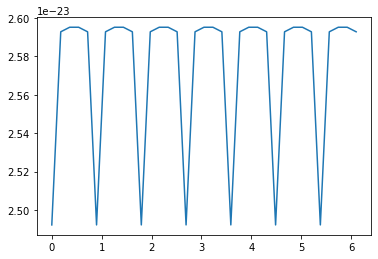

In [9]:
%matplotlib inline
plt.plot(phis, fn[:,2])

In [13]:
on[:,1]

array([ 1.64257683e-25,  1.04325576e-24,  0.00000000e+00, -1.04325576e-24,
       -1.64257683e-25])

In [9]:
oy[:,0,0]

array([-3.48403780e-22, -3.48296046e-22, -3.20174005e-22, -3.48296046e-22,
       -3.48403780e-22])

In [23]:
zeros = sym_attractor_profile(R, height)
zeros.build(lambda pos: nholes(pos[0], pos[1], pos[2], R=R, hr=hr, from_edge=dist_from_edge), N=N)

Building Attractor: 100%|██████████| 1001/1001 [00:02<00:00, 401.93it/s]


In [24]:
phis, newt, yuka = zeros.full_gravity(20., 5., lambdas=np.array([10e-6]), nphi=100)

In [17]:
np.sum(newt, axis=1)

array([-7.68682529e-22, -5.96978622e-24,  2.49404041e-23])

In [313]:
lams = np.array([10e-6, 50e-6])
start = time.time()
phis, newtf, yukaf = sym_test.full_gravity(20, 5, lambdas=lams, nphi=5)
print(f'{(time.time()-start)/(5*10*3):.2f} per phi')

2.28 per phi


In [319]:
newt_interp = intp.interp1d(phis, newtf.T, kind='cubic', axis=1)
yuka_interp = intp.interp1d(phis, np.swapaxes(yukaf[:,1,:], 0, 1), kind='cubic', axis=1)

In [257]:
normal = attractor_profile(R, height, Rb=Rb, rhob=rhob)
normal.build(lambda pos: uniform(pos[0], pos[1], pos[2]), cyl_sym=True)

Building Attractor: 100%|██████████| 1022/1022 [00:06<00:00, 157.63it/s]


In [258]:
normal.newtonian((1100., 0., 0.))

array([-2.12931253e-22,  1.68688148e-39, -1.49956452e-42])

In [285]:
radial = []
angular = []
phis = np.arange(0, 2*np.pi, np.pi/4)

for phi in phis:
    newt, phis = sym_test.newtonian((1100., phi, 0.))
    Fg = np.sum(newt, axis=1)
    radial.append(Fg[0])
    angular.append(Fg[1])

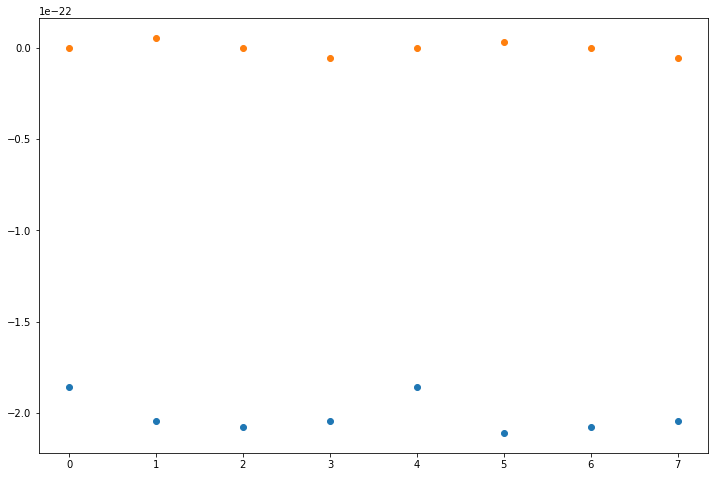

In [286]:
plt.plot(radial, 'o')
plt.plot(angular, 'o')

In [281]:
np.std(radial), np.std(angular)

(0.0, 0.0)

In [288]:
nphi = 50
start = time.time()
Fg = sym_test.full_newtonian(25, 10, nphi=nphi, debug=False)
end = time.time()
print(f'Full newtonian took {(end-start)/60:.2f} min for {nphi*N} phi')
print(f'Avg of {(end-start)/(nphi*N):.2f} s per phi')

Full newtonian took 13.42 min for 500 phi
Avg of 1.61 s per phi


In [291]:
phis, newt = Fg
phis.shape, newt.shape

((500,), (3, 500))

In [295]:
newt_interp = intp.interp1d(phis, newt, kind='cubic', axis=1)
phis_range = np.linspace(0,np.max(phis), 1000)
newt_f = newt_interp(phis_range)

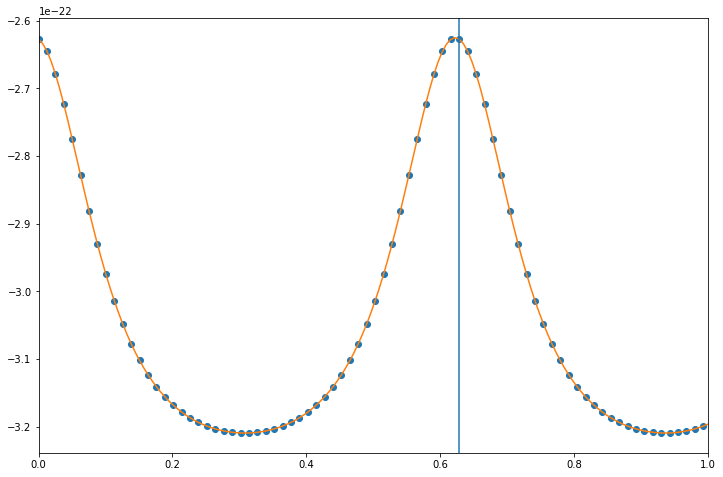

In [306]:
plt.plot(phis, newt[0,:], 'o')
plt.plot(phis_range, newt_f[0])
plt.xlim(0,1)
plt.axvline(np.pi/5)

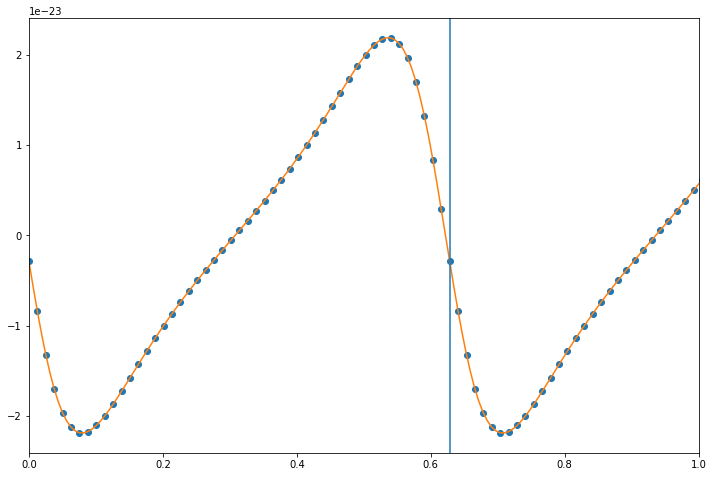

In [302]:
plt.plot(phis, newt[1,:], 'o')
plt.plot(phis_range, newt_f[1])
plt.xlim(0,1)
plt.axvline(np.pi/5)

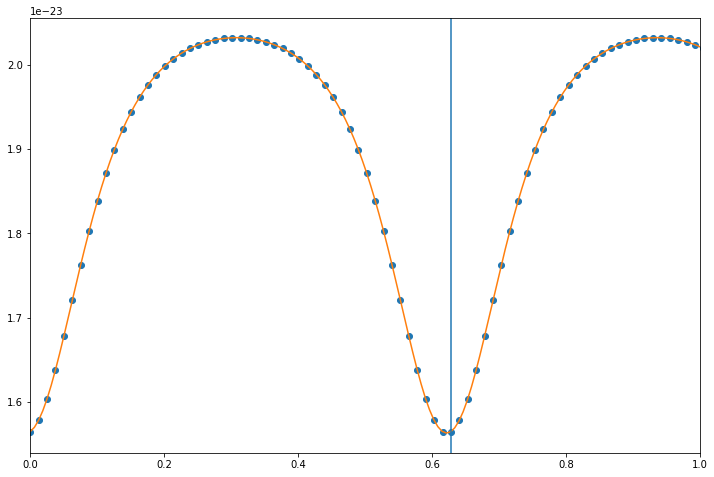

In [307]:
plt.plot(phis, newt[2,:], 'o')
plt.plot(phis_range, newt_f[2])
plt.xlim(0,1)
plt.axvline(np.pi/5)

## What even is this

In [31]:
# parent = os.getcwd()
# os.chdir('./sim_data/times_test/')

# with open('attractor_profile.p', 'rb') as file:
#     big_test = pickle.load(file)
    
# os.chdir(parent)

In [32]:
sym_test.sector_com()

(636.6145663740374, -7.825156624467217e-14)

In [21]:
testn = sym_test.newtonian((R+100, 0., 0.))

Avg comp time: 3.43 s
Avg add time: 0.01 ms


In [32]:
-6.67e-11*(np.pi*1000e-6**2*100e-6)*rho_attractor*(4/3)*np.pi*(Rb*1e-6)**3*rhob / (1100e-6)**2

-1.4212116958598475e-22

In [33]:
np.sum(testn[0][0,:])

-2.516386777479415e-22

In [31]:
6*sym_test.sum_dm

6.063279876370002e-06

In [30]:
(np.pi*1000e-6**2*100e-6)*rho_attractor

6.0632738214283e-06

In [15]:
xcm = 2/3 * R * np.sin(np.pi/N)/(np.pi/N)
xcm

636.6197723675813

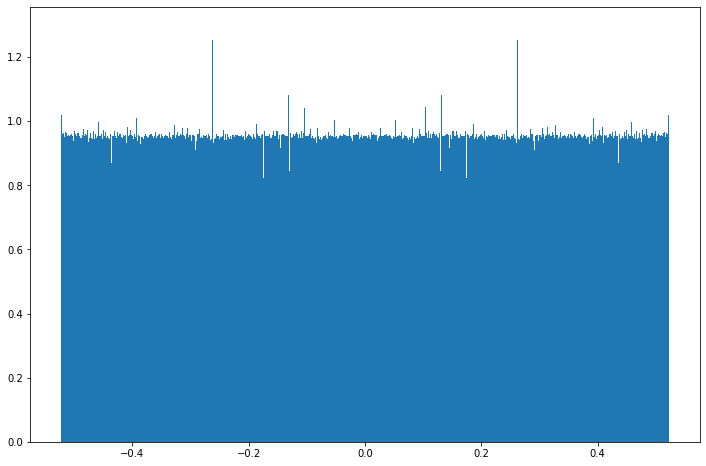

In [37]:
PP = np.array([])
for r, partition in sym_test.data.items():
    pp = partition['params'][3]
    pp[pp>np.pi]-=2*np.pi
    PP = np.concatenate((PP, pp))

plt.hist(PP, density=True, bins=1000)
plt.show()

In [5]:
sep = 100

In [16]:
M = np.pi*(R*1e-6)**2 * (100*1e-6) * rho_attractor
print(M, ', ', M/N, '==?', sym_test.sum_dm)
print()
Fg_exp = -6.67e-11*(M/N)*4*np.pi*(Rb*1e-6)**3*1850. / (3*((R+sep-xcm)*1e-6)**2)
print(Fg_exp)

6.0632738214283e-06 ,  1.0105456369047168e-06 ==? 1.010546646061667e-06

-1.334805217799296e-22


In [39]:
Fg_analytical = lambda sep: (-6.67e-11*(M/N)*4*np.pi*(Rb*1e-6)**3*1850. / (3*((R+sep-xcm)*1e-6)**2))

In [12]:
newt_slice = sym_test.sector_newtonian((R+sep, 0., 0.), include_zero=True)
newt_slice

(1, 100)
(100,)


array([-1.65407792e-22,  1.18208771e-38, -1.11252971e-42])

In [40]:
seps = np.linspace(10, 150, 25)
ratio = []

for sep in seps:
    ratio.append(sym_test.sector_newtonian((R+sep, 0., 0.), include_zero=True)[0]/Fg_analytical(sep))

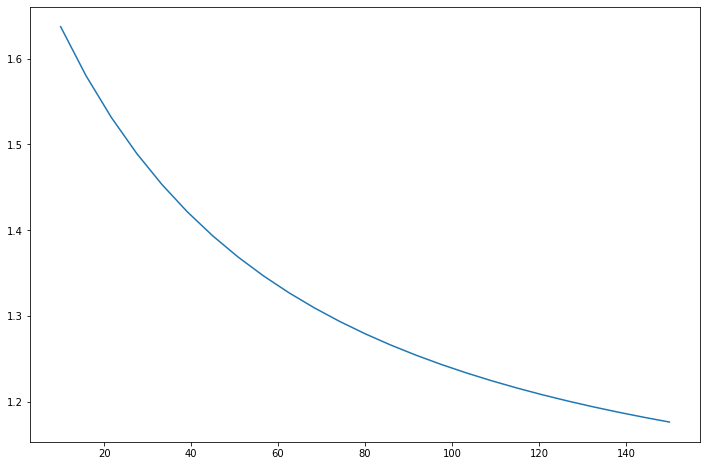

In [46]:
plt.plot(seps, ratio)

In [17]:
newt_slice[0]/Fg_exp

1.2391904806412049

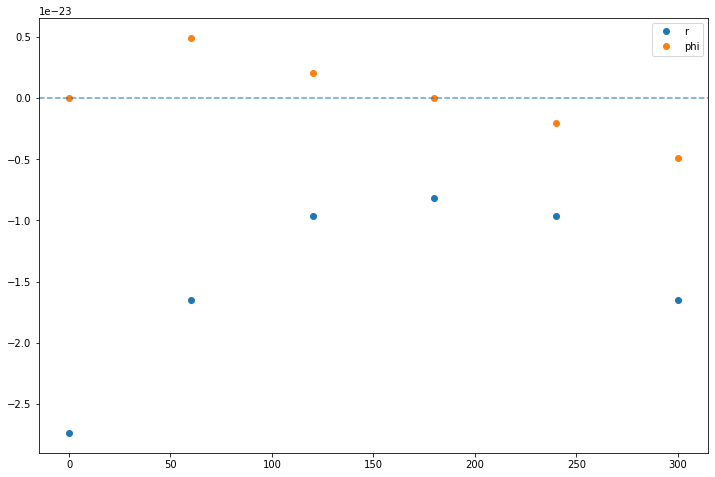

In [225]:
plt.plot(phis*180/np.pi, newt[0,:], 'o', label='r')
plt.plot(phis*180/np.pi, newt[1,:], 'o', label='phi')
plt.axhline(0,0,2*np.pi, ls='--', alpha=0.7)
plt.legend()
plt.show()

In [53]:
mb = (4/3)*np.pi*(5e-6)**3*1850.
6.67e-11*mb/(np.sqrt(2)*100e-6)**2

3.2304735457476042e-15

In [55]:
3.230474e-15*np.cos(np.pi/4)

2.284290071846831e-15

In [56]:
rb_vec = (100., 0., 0.)

G = 6.67e-11
Fg = np.array([0.,0.,0.])
rb, pb, zb = rb_vec
rb = rb*1e-6
zb = zb*1e-6

rhob = 1850.
Rb = 5e-6

r = 100e-6
pp = np.array([np.pi/2])
dm_arr = np.array([1.0])
zz = np.array([0.])

# create coordinate arrays to compute force vector at
psep, zsep = np.meshgrid(pp - pb, zz - zb, indexing='ij')
rsep = rb - r

# separation between attractor mesh and bead
sep = np.sqrt((rb**2) + (r**2) - 2*rb*r*np.cos(psep) + zsep**2)

# separation in only r,phi
sep_rp = np.sqrt((rb**2) + (r**2) - 2*rb*r*np.cos(psep))

# get full vector force at every point in meshgrid (i.e. every r,phi,z in partition)
full_vec_force = -1.0 * (4.*G*dm_arr*rhob*np.pi*Rb**3)/(3.*sep**2)

# add 1% white noise
# full_vec_force += np.random.randn()*full_vec_force/100

# get projections onto each unit vector and sum the force at all points on the partition
Fg[0] += np.sum(full_vec_force * (rb-r*np.cos(psep))/sep_rp)
Fg[1] += np.sum(full_vec_force * (r*np.sin(psep))/sep_rp)
Fg[2] += np.sum(full_vec_force * (zsep/sep))   

print(Fg)

[-2.28428975e-15 -2.28428975e-15  0.00000000e+00]


In [57]:
rb_vec = (100., 0., 0.)

G = 6.67e-11
Fg = np.array([0.,0.,0.])
rb, pb, zb = rb_vec
rb = rb*1e-6
zb = zb*1e-6

rhob = 1850.
Rb = 5e-6

r = 100e-6
pp = np.array([3*np.pi/2])
dm_arr = np.array([1.0])
zz = np.array([0.])

# create coordinate arrays to compute force vector at
psep, zsep = np.meshgrid(pp - pb, zz - zb, indexing='ij')
rsep = rb - r

# separation between attractor mesh and bead
sep = np.sqrt((rb**2) + (r**2) - 2*rb*r*np.cos(psep) + zsep**2)

# separation in only r,phi
sep_rp = np.sqrt((rb**2) + (r**2) - 2*rb*r*np.cos(psep))

# get full vector force at every point in meshgrid (i.e. every r,phi,z in partition)
full_vec_force = -1.0 * (4.*G*dm_arr*rhob*np.pi*Rb**3)/(3.*sep**2)

# add 1% white noise
# full_vec_force += np.random.randn()*full_vec_force/100

# get projections onto each unit vector and sum the force at all points on the partition
Fg[0] += np.sum(full_vec_force * (rb-r*np.cos(psep))/sep_rp)
Fg[1] += np.sum(full_vec_force * (r*np.sin(psep))/sep_rp)
Fg[2] += np.sum(full_vec_force * (zsep/sep))   

print(Fg)

[-2.28428975e-15  2.28428975e-15  0.00000000e+00]


In [79]:
rb_vec = (100., 0., 0.)

G = 6.67e-11
Fg = np.array([0.,0.,0.])
rb, pb, zb = rb_vec
rb = rb*1e-6
zb = zb*1e-6

rhob = 1850.
Rb = 5e-6

r = 100e-6
pp = np.array([np.pi/2, 3*np.pi/2])
dm_arr = np.array([[0.5], [0.5]])
zz = np.array([0.])

# create coordinate arrays to compute force vector at
psep, zsep = np.meshgrid(pp - pb, zz - zb, indexing='ij')
rsep = rb - r

# separation between attractor mesh and bead
sep = np.sqrt((rb**2) + (r**2) - 2*rb*r*np.cos(psep) + zsep**2)

# separation in only r,phi
sep_rp = np.sqrt((rb**2) + (r**2) - 2*rb*r*np.cos(psep))

# get full vector force at every point in meshgrid (i.e. every r,phi,z in partition)
full_vec_force = -1.0 * (4.*G*dm_arr*rhob*np.pi*Rb**3)/(3.*sep**2)

# add 1% white noise
# full_vec_force += np.random.randn()*full_vec_force/100

# get projections onto each unit vector and sum the force at all points on the partition
Fg[0] += np.sum(full_vec_force * (rb-r*np.cos(psep))/sep_rp)
Fg[1] += np.sum(full_vec_force * (r*np.sin(psep))/sep_rp)
Fg[2] += np.sum(full_vec_force * (zsep/sep))   

print(Fg)

[-2.28428975e-15  0.00000000e+00  0.00000000e+00]


In [39]:
(1e-6)**3*rho_attractor

1.9299999999999997e-14

In [41]:
(4/3)*np.pi*(Rb*1e-6)**3 * rhob

4.2521749781652167e-13

In [80]:
sep, np.sqrt(2)*100e-6

(array([[0.00014142],
        [0.00014142]]),
 0.0001414213562373095)

In [81]:
full_vec_force

array([[-1.61523677e-15],
       [-1.61523677e-15]])

In [87]:
fullF = 6.67e-11*mb*0.5/(np.sqrt(2)*100e-6)**2
fullF

1.6152367728738021e-15

In [88]:
np.cos(np.pi/4)*fullF

1.142144875320941e-15

In [83]:
full_vec_force * (rb-r*np.cos(psep))/sep_rp

array([[-1.14214488e-15],
       [-1.14214488e-15]])

In [84]:
sep.shape

(2, 1)

In [85]:
dm_arr.shape

(2, 1)

In [86]:
(dm_arr/sep**2).shape

(2, 1)